In [ ]:
# SFO Air Traffic EDA Notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

df = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')

print("--- First 5 rows of the dataset ---")
print(df.head())
print("\n--- Dataset Information ---")
df.info()


--- First 5 rows of the dataset ---
   Activity Period Activity Period Start Date  \
0           199907                 1999/07/01   
1           199907                 1999/07/01   
2           199907                 1999/07/01   
3           199907                 1999/07/01   
4           199907                 1999/07/01   

                         Operating Airline Operating Airline IATA Code  \
0                             ATA Airlines                          TZ   
1                             ATA Airlines                          TZ   
2                             ATA Airlines                          TZ   
3  Aeroflot Russian International Airlines                         NaN   
4  Aeroflot Russian International Airlines                         NaN   

                         Published Airline Published Airline IATA Code  \
0                             ATA Airlines                          TZ   
1                             ATA Airlines                          TZ   
2 

In [ ]:
# ==============================================================================
# 2. DATA CLEANING AND PREPROCESSING
# ==============================================================================

# Standardize column names by stripping whitespace, replacing spaces and hyphens with underscores, and converting to lowercase.
df.columns = (
    df.columns
     .str.strip()
     .str.replace(' ', '_')
     .str.replace('-', '_')
     .str.lower()
)
print("\n--- Columns after standardization ---")
print(df.columns)

# Convert date columns to datetime objects for proper time-series analysis.
# The format '%Y-%m-%d' is used to match the 'activity_period_start_date' column format.
df['activity_period'] = pd.to_datetime(df['activity_period_start_date'])
df['activity_period_start_date'] = pd.to_datetime(df['activity_period_start_date'])
df['data_as_of'] = pd.to_datetime(df['data_as_of'])
df['data_loaded_at'] = pd.to_datetime(df['data_loaded_at'])


# Fill missing values in airline IATA codes with 'Unknown'.
df['operating_airline_iata_code'] = df['operating_airline_iata_code'].fillna('Unknown')
df['published_airline_iata_code'] = df['published_airline_iata_code'].fillna('Unknown')

# Drop duplicate rows to ensure data uniqueness.
initial_rows = len(df)
df = df.drop_duplicates()
print(f"\nDropped {initial_rows - len(df)} duplicate rows.")

# Remove rows with negative passenger counts as they are invalid data.
initial_rows = len(df)
df = df[df['passenger_count'] >= 0]
print(f"Dropped {initial_rows - len(df)} rows with negative passenger counts.")

# Extract year, month, and month name from the 'activity_period_start_date' for time-based analysis.
df['year'] = df['activity_period_start_date'].dt.year
df['month'] = df['activity_period_start_date'].dt.month
df['month_name'] = df['activity_period_start_date'].dt.strftime('%B')

# Consolidate variations of "United Airlines" into a single name for consistency.
df['operating_airline'] = df['operating_airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'})
df['published_airline'] = df['published_airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'})
print("\n'United Airlines - Pre 07/01/2013' consolidated into 'United Airlines'.")

# Display the count of missing values for each column after cleaning.
print("\n--- Missing values per column after cleaning ---")
print(df.isnull().sum())

# Display a sample of the cleaned data with the newly engineered features.
print("\n--- Sample of cleaned and feature-engineered data ---")
print(df[['activity_period_start_date', 'year', 'month_name', 'operating_airline', 'passenger_count']].head())

# Save the cleaned and processed data to a new CSV file.
output_filename = 'fully_cleaned_sfo_passenger_data.csv'
df.to_csv(output_filename, index=False)
print(f"\nCleaning complete. Saved to '{output_filename}'.")


--- Columns after standardization ---
Index(['activity_period', 'activity_period_start_date', 'operating_airline',
       'operating_airline_iata_code', 'published_airline',
       'published_airline_iata_code', 'geo_summary', 'geo_region',
       'activity_type_code', 'price_category_code', 'terminal',
       'boarding_area', 'passenger_count', 'data_as_of', 'data_loaded_at'],
      dtype='object')

Dropped 0 duplicate rows.
Dropped 0 rows with negative passenger counts.


/tmp/ipython-input-2881450556.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data_as_of'] = pd.to_datetime(df['data_as_of'])



'United Airlines - Pre 07/01/2013' consolidated into 'United Airlines'.

--- Missing values per column after cleaning ---
activity_period                0
activity_period_start_date     0
operating_airline              0
operating_airline_iata_code    0
published_airline              0
published_airline_iata_code    0
geo_summary                    0
geo_region                     0
activity_type_code             0
price_category_code            0
terminal                       0
boarding_area                  0
passenger_count                0
data_as_of                     0
data_loaded_at                 0
year                           0
month                          0
month_name                     0
dtype: int64

--- Sample of cleaned and feature-engineered data ---
  activity_period_start_date  year month_name  \
0                 1999-07-01  1999       July   
1                 1999-07-01  1999       July   
2                 1999-07-01  1999       July   
3                 1


Displaying chart for: Long-Term Growth and Volatility


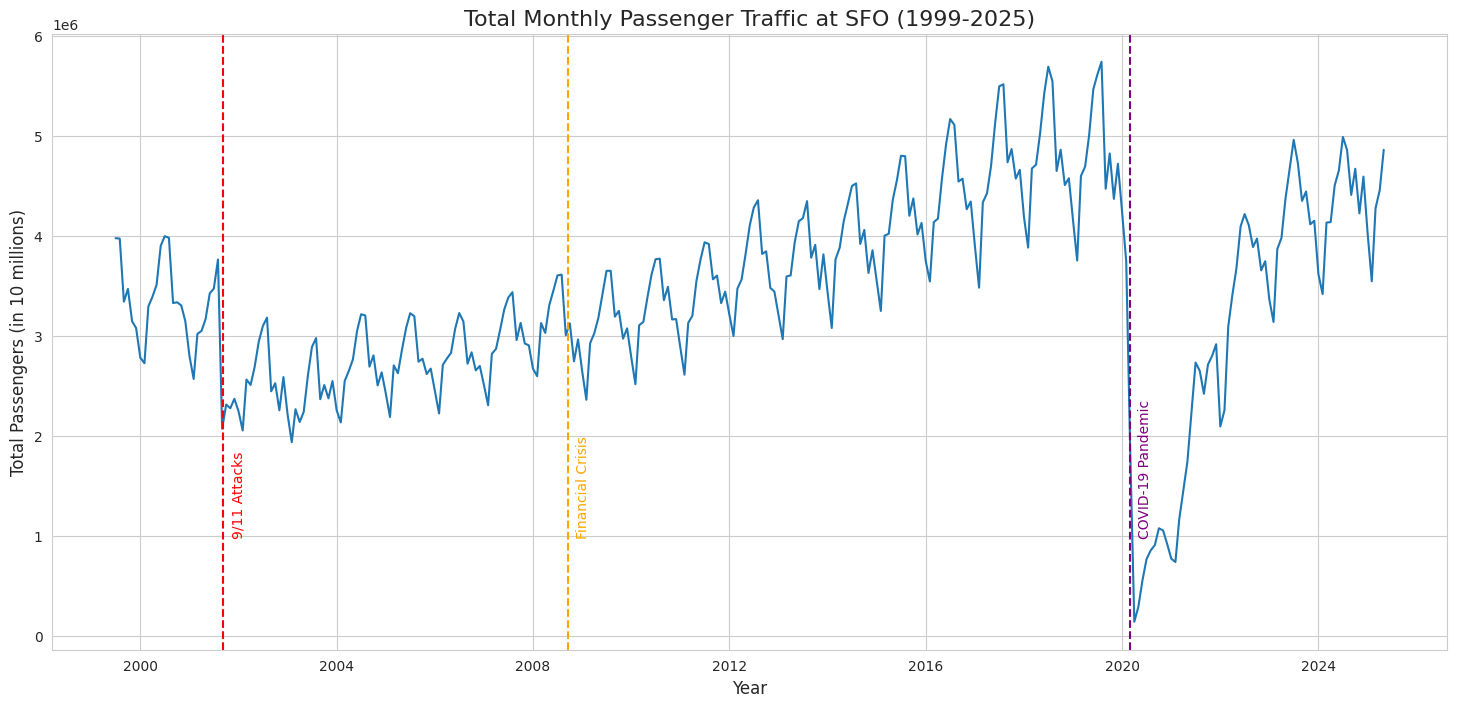

/tmp/ipython-input-2307129364.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=monthly_aggregated_traffic, x='month_name', y='passenger_count', order=month_order, palette='coolwarm')



Displaying chart for: Seasonality and Cyclical Patterns


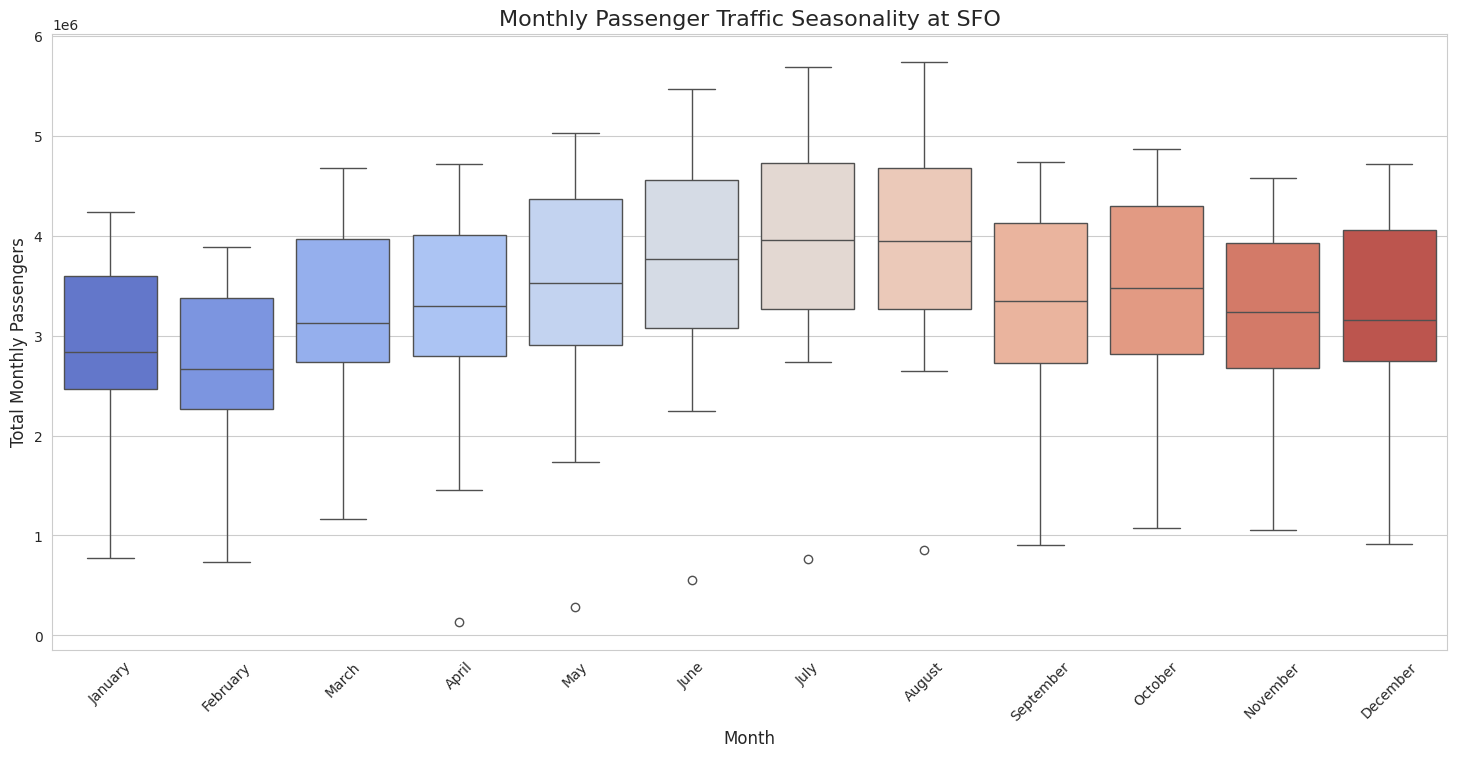

In [ ]:
# ==============================================================================
# 3. MACRO-LEVEL TRENDS IN PASSENGER TRAFFIC
# ==============================================================================
# This section corresponds to "Macro-Level Trends in Passenger Traffic at SFO" in the report.

# --- 3.1 Long-Term Growth and Volatility ---
# Aggregate total passenger count by month to visualize the overall trend.
monthly_traffic = df.groupby('activity_period_start_date')['passenger_count'].sum().reset_index()

plt.figure(figsize=(18, 8))
sns.lineplot(data=monthly_traffic, x='activity_period_start_date', y='passenger_count')
plt.title('Total Monthly Passenger Traffic at SFO (1999-2025)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Passengers (in 10 millions)', fontsize=12)

# Add vertical lines to mark major global events that impacted air travel.
plt.axvline(pd.to_datetime('2001-09-11'), color='red', linestyle='--', lw=1.5)
plt.text(pd.to_datetime('2001-09-11') + pd.Timedelta(days=60), 1e6, '9/11 Attacks', rotation=90, color='red')
plt.axvline(pd.to_datetime('2008-09-15'), color='orange', linestyle='--', lw=1.5)
plt.text(pd.to_datetime('2008-09-15') + pd.Timedelta(days=60), 1e6, 'Financial Crisis', rotation=90, color='orange')
plt.axvline(pd.to_datetime('2020-03-01'), color='purple', linestyle='--', lw=1.5)
plt.text(pd.to_datetime('2020-03-01') + pd.Timedelta(days=60), 1e6, 'COVID-19 Pandemic', rotation=90, color='purple')

print("\nDisplaying chart for: Long-Term Growth and Volatility")
plt.show()


# --- 3.2 Seasonality and Cyclical Patterns ---
# Use a box plot to show the distribution of passenger traffic for each month across all years.
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

monthly_aggregated_traffic = df.groupby(['year', 'month_name'])['passenger_count'].sum().reset_index()

plt.figure(figsize=(18, 8))
sns.boxplot(data=monthly_aggregated_traffic, x='month_name', y='passenger_count', order=month_order, palette='coolwarm')
plt.title('Monthly Passenger Traffic Seasonality at SFO', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Monthly Passengers', fontsize=12)
plt.xticks(rotation=45)
print("\nDisplaying chart for: Seasonality and Cyclical Patterns")
plt.show()

/tmp/ipython-input-3974058341.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_airlines.index, y=top_10_airlines.values, palette='viridis')



Displaying chart for: Market Share Dominance


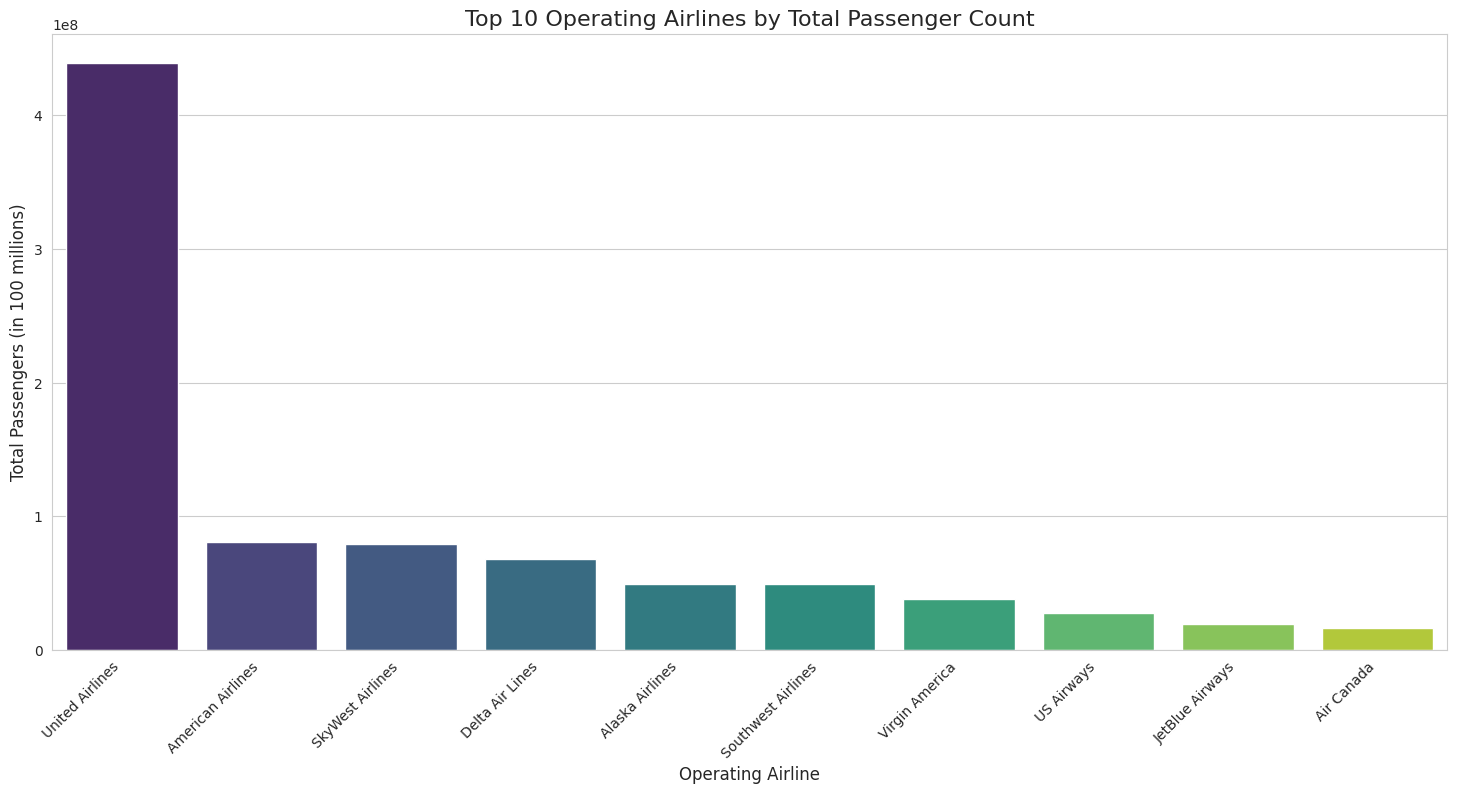


Displaying chart for: Role of Regional Carriers (United Airlines Case Study)


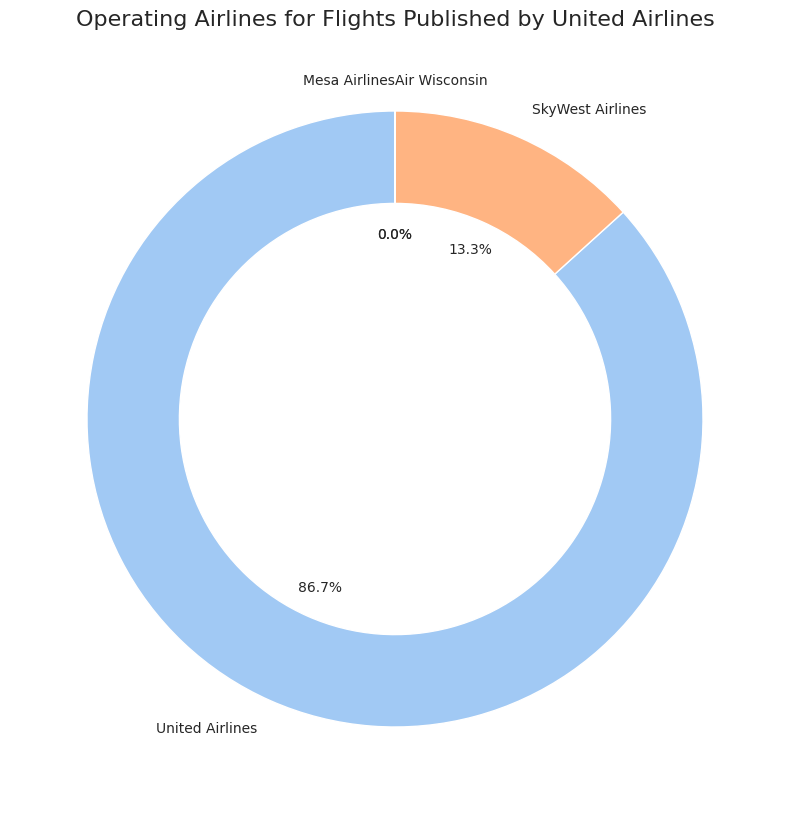


Displaying chart for: Low-Cost vs. Legacy Carriers


<Figure size 1800x800 with 0 Axes>

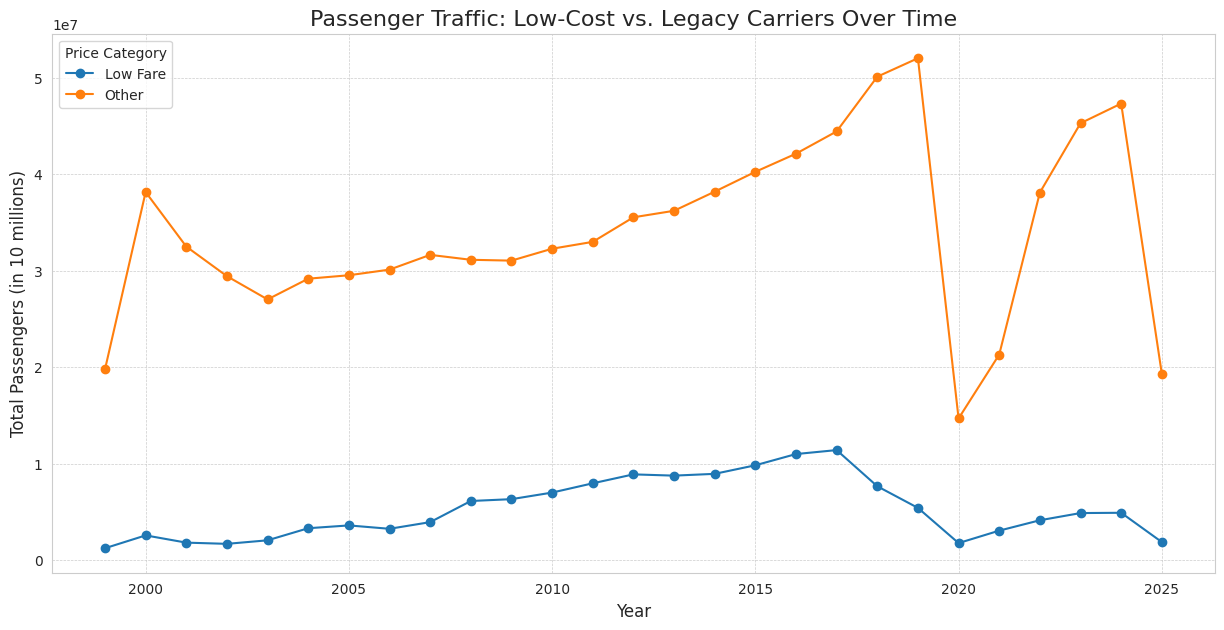

In [ ]:
# ==============================================================================
# 4. COMPETITIVE LANDSCAPE AND AIRLINE PERFORMANCE
# ==============================================================================
# This section corresponds to "Competitive Landscape and Airline Performance" in the report.

# --- 4.1 Market Share Dominance ---
# Calculate the total passenger count for each airline and identify the top 10.
top_10_airlines = df.groupby('operating_airline')['passenger_count'].sum().nlargest(10)

plt.figure(figsize=(18, 8))
sns.barplot(x=top_10_airlines.index, y=top_10_airlines.values, palette='viridis')
plt.title('Top 10 Operating Airlines by Total Passenger Count', fontsize=16)
plt.xlabel('Operating Airline', fontsize=12)
plt.ylabel('Total Passengers (in 100 millions)', fontsize=12)
plt.xticks(rotation=45, ha='right')
print("\nDisplaying chart for: Market Share Dominance")
plt.show()


# --- 4.2 The Role of Regional Carriers: Operating vs. Published Airlines ---
# Analyze flights published by United Airlines to see which airlines actually operate them.
united_published = df[df['published_airline'] == 'United Airlines']
operating_breakdown = united_published.groupby('operating_airline')['passenger_count'].sum().nlargest(5)

plt.figure(figsize=(10, 10))
operating_breakdown.plot(kind='pie', autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3), colors=sns.color_palette('pastel'))
plt.title('Operating Airlines for Flights Published by United Airlines', fontsize=16)
plt.ylabel('') # Hide the y-label
print("\nDisplaying chart for: Role of Regional Carriers (United Airlines Case Study)")
plt.show()


# --- 4.3 Performance of Low-Cost vs. Legacy Carriers ---
# Compare the passenger volume of "Low Fare" carriers versus "Other" carriers over time.
price_category_trends = df.groupby(['year', 'price_category_code'])['passenger_count'].sum().unstack()

plt.figure(figsize=(18, 8))
price_category_trends.plot(kind='line', marker='o', linestyle='-')
plt.title('Passenger Traffic: Low-Cost vs. Legacy Carriers Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Passengers (in 10 millions)', fontsize=12)
plt.legend(title='Price Category')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
print("\nDisplaying chart for: Low-Cost vs. Legacy Carriers")
plt.show()



Displaying chart for: Domestic vs. International Traffic


<Figure size 1800x800 with 0 Axes>

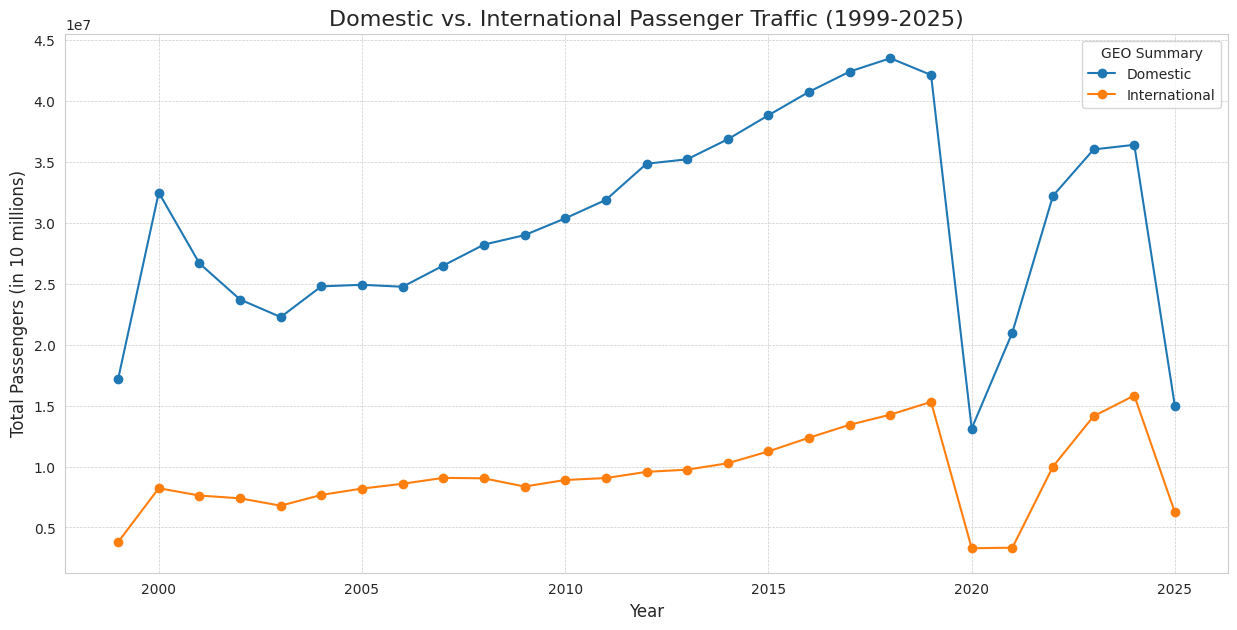


Displaying chart for: Top International Regions


/tmp/ipython-input-3693067332.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_regions.index, y=top_regions.values, palette='plasma')


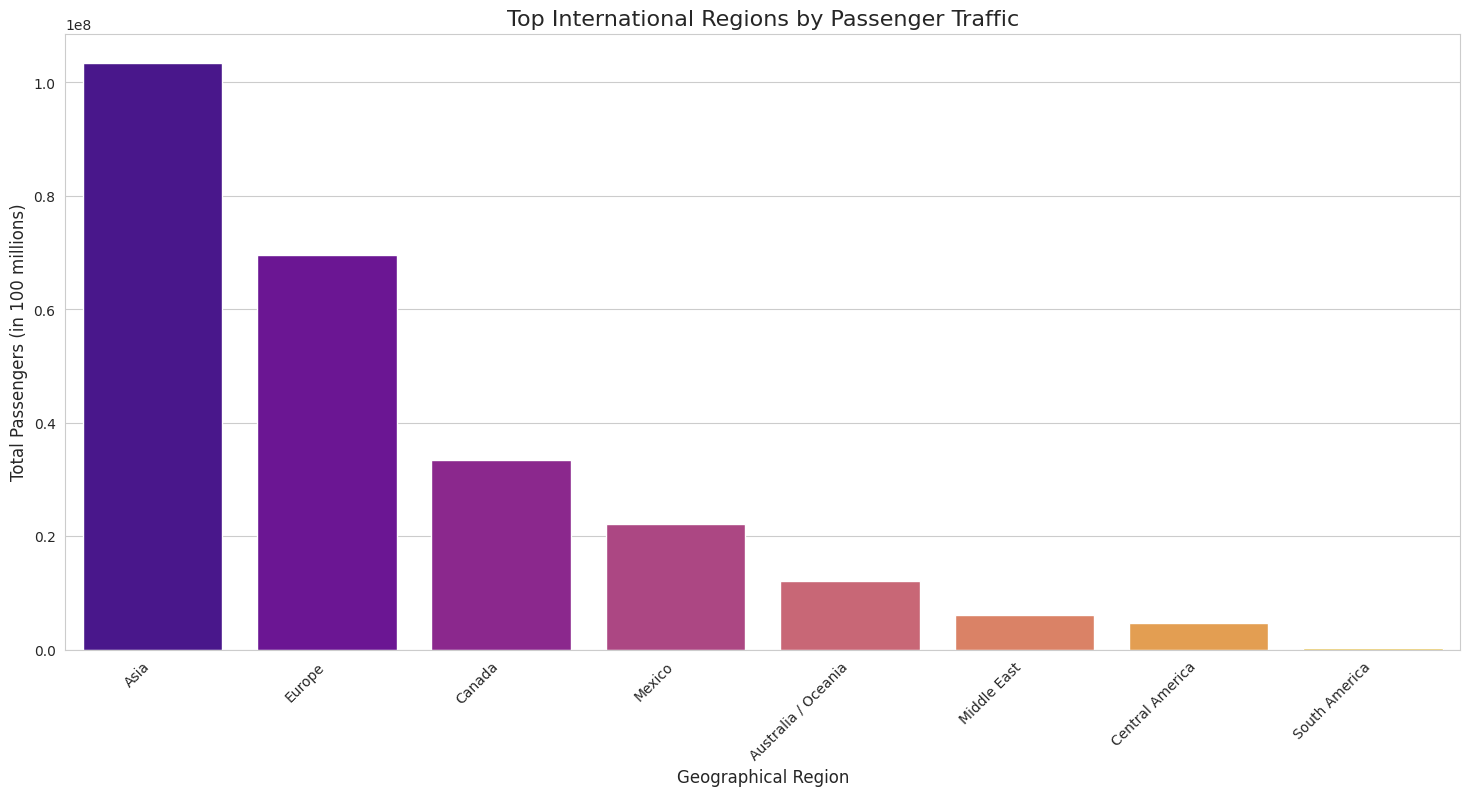

In [ ]:

# ==============================================================================
# 5. GEOGRAPHICAL FLOW OF PASSENGER TRAFFIC
# ==============================================================================
# This section corresponds to "Geographical Flow of Passenger Traffic" in the report.

# --- 5.1 Domestic vs. International Traffic Dynamics ---
# Plot the trends of domestic and international traffic to compare their growth and recovery patterns.
geo_summary_trends = df.groupby(['year', 'geo_summary'])['passenger_count'].sum().unstack()

plt.figure(figsize=(18, 8))
geo_summary_trends.plot(kind='line', marker='o', linestyle='-')
plt.title('Domestic vs. International Passenger Traffic (1999-2025)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Passengers (in 10 millions)', fontsize=12)
plt.legend(title='GEO Summary')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
print("\nDisplaying chart for: Domestic vs. International Traffic")
plt.show()


# --- 5.2 Analysis of Top International Regions ---
# Identify the key international regions driving traffic to and from SFO.
international_traffic = df[df['geo_summary'] == 'International']
top_regions = international_traffic.groupby('geo_region')['passenger_count'].sum().nlargest(10)

plt.figure(figsize=(18, 8))
sns.barplot(x=top_regions.index, y=top_regions.values, palette='plasma')
plt.title('Top International Regions by Passenger Traffic', fontsize=16)
plt.xlabel('Geographical Region', fontsize=12)
plt.ylabel('Total Passengers (in 100 millions)', fontsize=12)
plt.xticks(rotation=45, ha='right')
print("\nDisplaying chart for: Top International Regions")
plt.show()



Displaying chart for: Passenger Volume by Terminal


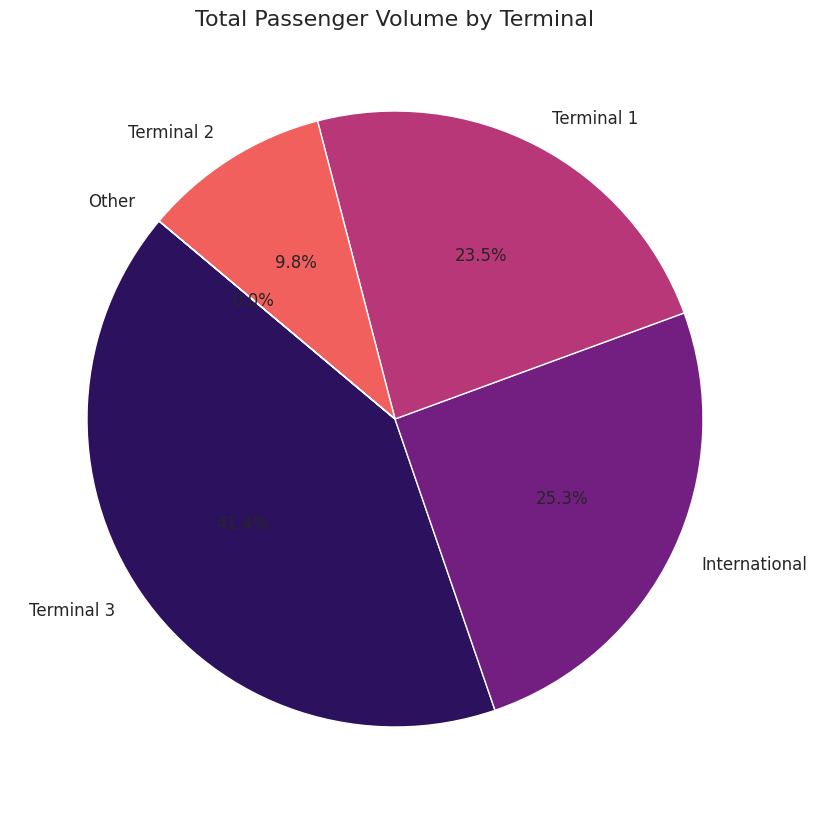


Displaying chart for: Passenger Activity Flow


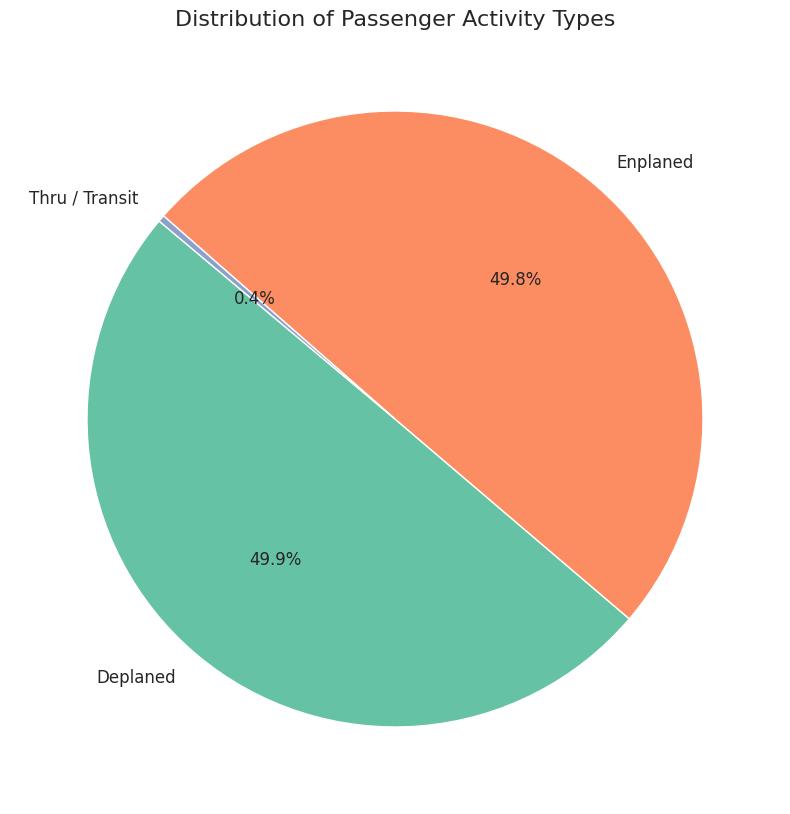

In [ ]:
# ==============================================================================
# 6. SFO TERMINAL AND INFRASTRUCTURE UTILIZATION
# ==============================================================================

# Group data by terminal and sum passenger counts to get total traffic per terminal.
terminal_traffic = df.groupby('terminal')['passenger_count'].sum().sort_values(ascending=False)

# Define the color palette to be used for the pie chart.
colors = sns.color_palette('magma', len(terminal_traffic))

# Create a pie chart to visualize the distribution of passenger volume by terminal.
plt.figure(figsize=(10, 10))
terminal_traffic.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
plt.title('Total Passenger Volume by Terminal', fontsize=16)
plt.ylabel('') # Remove the default y-label for pie charts
print("\nDisplaying chart for: Passenger Volume by Terminal")
plt.show()

# Group data by activity type code and sum passenger counts to see the distribution of activity types.
activity_type_dist = df.groupby('activity_type_code')['passenger_count'].sum()

# Create a pie chart to visualize the distribution of passenger activity types.
plt.figure(figsize=(10, 10))
activity_type_dist.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'), textprops={'fontsize': 12})
plt.title('Distribution of Passenger Activity Types', fontsize=16)
plt.ylabel('') # Remove the default y-label for pie charts
print("\nDisplaying chart for: Passenger Activity Flow")
plt.show()

In [ ]:
!pip install pmdarima numpy --upgrade statsmodels --upgrade

In [ ]:
# Convert date column to datetime objects
df['activity_period_start_date'] = pd.to_datetime(df['activity_period_start_date'])

# Aggregate data for time-series analysis (for Sections 1 and 2)
monthly_passengers = df.groupby('activity_period_start_date')['passenger_count'].sum().reset_index()
monthly_passengers = monthly_passengers.sort_values('activity_period_start_date')

# Add a time index column
monthly_passengers['time_index'] = np.arange(len(monthly_passengers))

SLR slope (passengers/month): 8955.830835159897
Intercept: 2323644.818137116
Test R^2: -1.283705533014344
Test RMSE: 2147947.5286686667


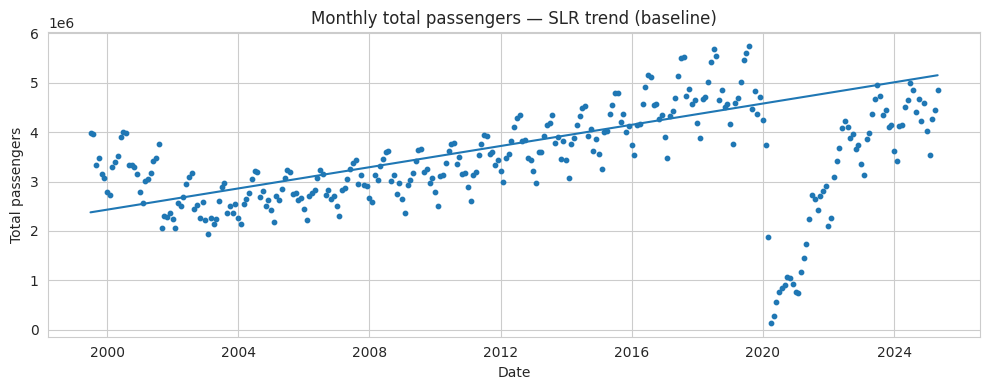

In [ ]:
# Simple Linear Regression (aggregate monthly total passengers)
# - Aggregate passenger_count by calendar month
# - Predictor: time index (months since start)
# - Note: this is only a baseline. Seasonality / shocks make SLR weak.

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# load cleaned file (update path if needed)
df = pd.read_csv("/content/fully_cleaned_sfo_passenger_data.csv")
df['activity_period_start_date'] = pd.to_datetime(df['activity_period_start_date'])

# aggregate per month (start-of-month bins)
df_month = (df.groupby(pd.Grouper(key='activity_period_start_date', freq='MS'))
              .passenger_count.sum()
              .reset_index()
              .rename(columns={'passenger_count': 'total_passengers'})
              .sort_values('activity_period_start_date'))

# time index (months since first month)
df_month['time_idx'] = ((df_month['activity_period_start_date'].dt.year - df_month['activity_period_start_date'].dt.year.min()) * 12
                        + (df_month['activity_period_start_date'].dt.month - df_month['activity_period_start_date'].dt.month.min()))

# time-aware split: earliest 80% months for training
split_idx = int(len(df_month) * 0.8)
train = df_month.iloc[:split_idx]
test  = df_month.iloc[split_idx:]

X_train = train[['time_idx']].values
y_train = train['total_passengers'].values
X_test  = test[['time_idx']].values
y_test  = test['total_passengers'].values

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print("SLR slope (passengers/month):", model.coef_[0])
print("Intercept:", model.intercept_)
print("Test R^2:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Plot actual vs fitted line (whole series)
plt.figure(figsize=(10,4))
plt.scatter(df_month['activity_period_start_date'], df_month['total_passengers'], s=10)
plt.plot(df_month['activity_period_start_date'], model.predict(df_month[['time_idx']].values))
plt.title("Monthly total passengers — SLR trend (baseline)")
plt.xlabel("Date")
plt.ylabel("Total passengers")
plt.tight_layout()
plt.show()

In [ ]:
# Multiple Linear Regression (row-level)
# - Predict passenger_count using: year, month, activity_type_code, geo_summary, terminal, boarding_area
# - One-hot encode categorical variables (drop_first=True to avoid trivial collinearity)
# - Returns sklearn predictive metrics and statsmodels OLS summary (p-values)

# Select columns
cols = ['year', 'month', 'activity_type_code', 'geo_summary', 'terminal', 'boarding_area', 'passenger_count']
df_ml = df[cols].copy()

# One-hot encode categorical predictors (drop_first avoids perfect multicollinearity from full dummies)
X = pd.get_dummies(df_ml.drop(columns='passenger_count'), drop_first=True)
y = df_ml['passenger_count']

print("Design matrix shape:", X.shape)

# Random train/test split (row-level regression)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert boolean columns in X_train to numeric (int)
for col in X_train.columns:
    if X_train[col].dtype == bool:
        X_train[col] = X_train[col].astype(int)

# sklearn linear regression (predictive)
sk_model = LinearRegression().fit(X_train, y_train)
y_pred = sk_model.predict(X_test)
print("SKLEARN: Test R^2:", r2_score(y_test, y_pred))
print("SKLEARN: Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# statsmodels OLS on training set for inference (p-values)
X_train_sm = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_sm).fit()
print(ols.summary())   # view coefficients and p-values

Design matrix shape: (38196, 16)
SKLEARN: Test R^2: 0.30211868521551355
SKLEARN: Test RMSE: 50805.5919358354
                            OLS Regression Results                            
Dep. Variable:        passenger_count   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     1068.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        08:02:41   Log-Likelihood:            -3.7495e+05
No. Observations:               30556   AIC:                         7.499e+05
Df Residuals:                   30542   BIC:                         7.500e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]

In [ ]:
# Backward elimination using statsmodels OLS p-values
# - Starts from the same design matrix as block (2)
# - Iteratively drops the feature with highest p-value (> 0.05) until all remaining features have p <= 0.05
# - Evaluates final model on held-out test set

import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("/content/fully_cleaned_sfo_passenger_data.csv")
cols = ['year', 'month', 'activity_type_code', 'geo_summary', 'terminal', 'boarding_area', 'passenger_count']
df_ml = df[cols].copy()
X = pd.get_dummies(df_ml.drop(columns='passenger_count'), drop_first=True)
y = df_ml['passenger_count']

# Train/test split (must be same approach as block 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert boolean columns in X_train to numeric (int) before backward elimination
for col in X_train.columns:
    if X_train[col].dtype == bool:
        X_train[col] = X_train[col].astype(int)

# Backward elimination
X_be = X_train.copy()
removed = []
iteration = 0
while True:
    iteration += 1
    X_be_sm = sm.add_constant(X_be)
    # Convert boolean columns in X_be_sm to numeric (int) before fitting the model
    for col in X_be_sm.columns:
        if X_be_sm[col].dtype == bool:
            X_be_sm[col] = X_be_sm[col].astype(int)

    model = sm.OLS(y_train, X_be_sm).fit()
    pvals = model.pvalues.drop('const', errors='ignore')
    if pvals.empty:
        break
    max_p = pvals.max()
    if max_p > 0.05:
        feat_to_remove = pvals.idxmax()
        removed.append((iteration, feat_to_remove, float(max_p)))
        X_be = X_be.drop(columns=[feat_to_remove])
    else:
        break
    if iteration > 200: # Safety break
        break

final_model = sm.OLS(y_train, sm.add_constant(X_be)).fit()
print("Removed features (iter, feature, pvalue):", removed)
print(final_model.summary())

# Evaluate on test set (drop removed features from X_test if present)
for _, feat, _ in removed:
    if feat in X_test.columns:
        X_test = X_test.drop(columns=[feat])
X_test_final = X_test[X_be.columns]   # ensure same order
X_test_final_sm = sm.add_constant(X_test_final)

# Convert boolean columns in X_test_final_sm to numeric (int) before prediction
for col in X_test_final_sm.columns:
    if X_test_final_sm[col].dtype == bool:
        X_test_final_sm[col] = X_test_final_sm[col].astype(int)

y_pred_test = final_model.predict(X_test_final_sm)
print("Final model test R^2:", r2_score(y_test, y_pred_test))
print("Final model test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

Removed features (iter, feature, pvalue): [(1, 'year', 0.2672888829545495)]
                            OLS Regression Results                            
Dep. Variable:        passenger_count   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     1157.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        08:02:41   Log-Likelihood:            -3.7495e+05
No. Observations:               30556   AIC:                         7.499e+05
Df Residuals:                   30543   BIC:                         7.500e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 9625, ncost: 32534.357197045825
Run: 1, iteration: 2/100, moves: 1991, ncost: 31558.83291206834
Run: 1, iteration: 3/100, moves: 797, ncost: 30511.70328271181
Run: 1, iteration: 4/100, moves: 477, ncost: 30141.549593620843
Run: 1, iteration: 5/100, moves: 567, ncost: 30114.372155100813
Run: 1, iteration: 6/100, moves: 163, ncost: 30112.62267022347
Run: 1, iteration: 7/100, moves: 47, ncost: 30112.43721515943
Run: 1, iteration: 8/100, moves: 18, ncost: 30112.426359694862
Run: 1, iteration: 9/100, moves: 2, ncost: 30112.426229417397
Run: 1, iteration: 10/100, moves: 0, ncost: 30112.426229417397
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 8407, ncost: 31430.872718013143
Run: 2, iteration: 2/100, moves: 954, ncost: 30551.203751925208
Run: 2, iteration: 3/100, moves: 661, ncost: 29597.219431979633
Run: 2, iterat

passenger_count                 activity_type_code    geo_summary  \
                   mean     min     max           <lambda>       <lambda>   
Cluster                                                                     
0               7357.58       0   71587           Deplaned  International   
1              14390.27       1  105940           Enplaned  International   
2              54538.00       0  206721           Enplaned       Domestic   
3             355520.77  201431  856501           Deplaned       Domestic   

              terminal boarding_area passenger_count_scaled  
              <lambda>      <lambda>                  count  
Cluster                                                      
0        International             A                  17680  
1        International             G                  11305  
2           Terminal 1             B                   8323  
3           Terminal 3             F                    888

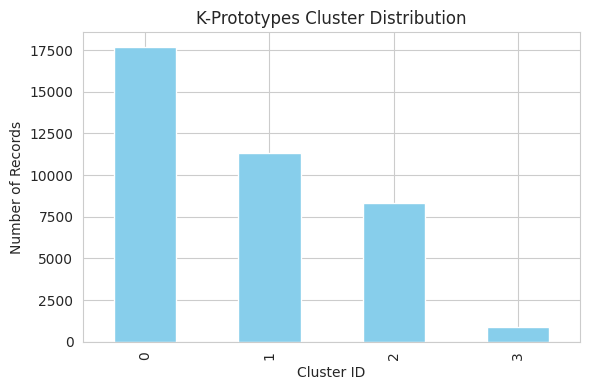

In [ ]:
# K-Prototypes Clustering (handles both numeric + categorical features)
# -------------------------------------------------------------
# Goal: Find operationally similar clusters across activity types, terminals, areas, etc.

!pip install kmodes --quiet

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

# Load cleaned data
df = pd.read_csv("/content/fully_cleaned_sfo_passenger_data.csv")

# Select relevant features (mix of numeric + categorical)
features = ['passenger_count', 'activity_type_code', 'geo_summary', 'terminal', 'boarding_area']
df_clust = df[features].dropna().copy()

# Normalize numeric column(s)
scaler = StandardScaler()
df_clust['passenger_count_scaled'] = scaler.fit_transform(df_clust[['passenger_count']])

# Prepare data for K-Prototypes: categorical columns must be string/object dtype
categorical_cols = ['activity_type_code', 'geo_summary', 'terminal', 'boarding_area']
for c in categorical_cols:
    df_clust[c] = df_clust[c].astype(str)

# Define input matrix (scaled numeric + categorical)
X = df_clust[['passenger_count_scaled'] + categorical_cols]

# Initialize and fit model
kproto = KPrototypes(n_clusters=4, random_state=42, init='Huang', n_init=5, verbose=1)
clusters = kproto.fit_predict(X, categorical=[1, 2, 3, 4])

# Assign clusters back to dataframe
df_clust['Cluster'] = clusters

# Display basic summary per cluster
cluster_summary = df_clust.groupby('Cluster').agg({
    'passenger_count': ['mean', 'min', 'max'],
    'activity_type_code': lambda x: x.mode()[0],
    'geo_summary': lambda x: x.mode()[0],
    'terminal': lambda x: x.mode()[0],
    'boarding_area': lambda x: x.mode()[0],
    'passenger_count_scaled': 'count'
}).round(2)

print("\nCluster summary (K-Prototypes):")
display(cluster_summary)

# Visualize cluster sizes
plt.figure(figsize=(6,4))
df_clust['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("K-Prototypes Cluster Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()

# Optional: store labeled data for analysis
df_clust.to_csv("sfo_kproto_clusters.csv", index=False)



Seasonal Clusters summary:


,total_passengers,yoy_change,mom_change
Season_Cluster,,,
0,2.334614e+06,0.216539,0.278656
1,4.276648e+06,0.088413,0.031685
2,2.829351e+06,0.044597,-0.053414
3,1.597482e+06,7.278312,0.224765


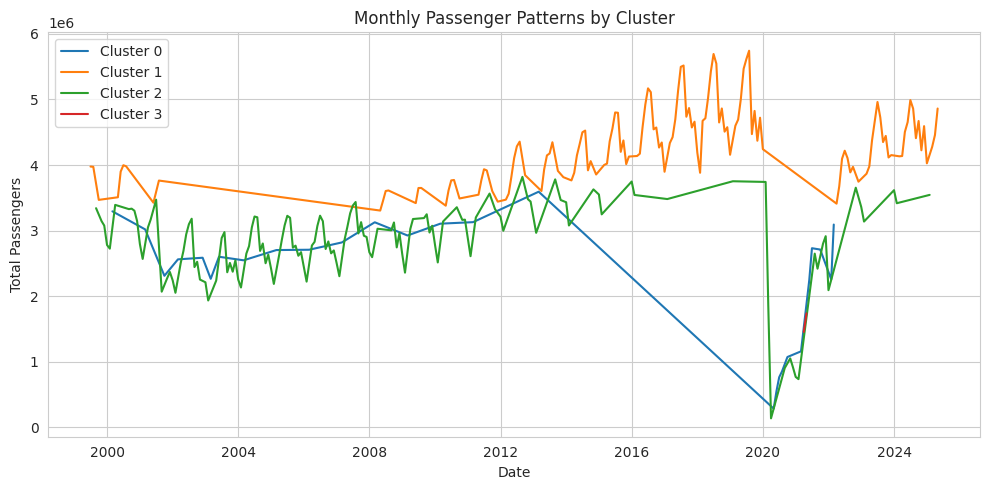

Cluster 3 likely represents anomalous/low-traffic months (e.g., COVID impact).


In [ ]:
# Seasonal Clustering on Monthly Passenger Totals
# -------------------------------------------------------------
# Goal: group months into patterns (peak, off-season, anomalous)

from sklearn.cluster import KMeans

# Load and aggregate monthly totals
df = pd.read_csv("/content/fully_cleaned_sfo_passenger_data.csv")
df['activity_period_start_date'] = pd.to_datetime(df['activity_period_start_date'])

df_month = (df.groupby(pd.Grouper(key='activity_period_start_date', freq='MS'))
              .passenger_count.sum()
              .reset_index()
              .rename(columns={'passenger_count': 'total_passengers'})
              .sort_values('activity_period_start_date'))

# Feature engineering: add month, year, lag-based differences
df_month['month'] = df_month['activity_period_start_date'].dt.month
df_month['year'] = df_month['activity_period_start_date'].dt.year
df_month['yoy_change'] = df_month['total_passengers'].pct_change(12).fillna(0)
df_month['mom_change'] = df_month['total_passengers'].pct_change().fillna(0)

# Scale numeric features
scaler = StandardScaler()
X = scaler.fit_transform(df_month[['total_passengers', 'yoy_change', 'mom_change']])

# Cluster months based on traffic dynamics
kmeans = KMeans(n_clusters=4, random_state=42)
df_month['Season_Cluster'] = kmeans.fit_predict(X)

# Show cluster means
cluster_means = df_month.groupby('Season_Cluster')[['total_passengers','yoy_change','mom_change']].mean()
print("\nSeasonal Clusters summary:")
display(cluster_means)

# Visualize
plt.figure(figsize=(10,5))
for c in sorted(df_month['Season_Cluster'].unique()):
    cluster_df = df_month[df_month['Season_Cluster'] == c]
    plt.plot(cluster_df['activity_period_start_date'], cluster_df['total_passengers'], label=f'Cluster {c}')
plt.legend()
plt.title("Monthly Passenger Patterns by Cluster")
plt.xlabel("Date")
plt.ylabel("Total Passengers")
plt.tight_layout()
plt.show()

# Optional: mark anomalies (lowest traffic months)
low_cluster = cluster_means['total_passengers'].idxmin()
print(f"Cluster {low_cluster} likely represents anomalous/low-traffic months (e.g., COVID impact).")


In [ ]:
# FURTHER STEPS
# Assign cluster labels to the main dataset
df['cluster'] = kproto.labels_

# Profile clusters
cluster_profile = df.groupby('cluster').agg({
    'passenger_count': ['mean', 'sum'],
    'month': lambda x: x.value_counts().index[0],  # most common month
    'activity_type_code': lambda x: x.value_counts().index[0],
    'geo_region': lambda x: x.value_counts().index[0],
})
cluster_profile


passenger_count               month activity_type_code geo_region
                   mean        sum <lambda>           <lambda>   <lambda>
cluster                                                                  
0           7357.578563  130081989        2           Deplaned       Asia
1          14390.273507  162682042        7           Enplaned       Asia
2          54537.995675  453919738        7           Enplaned         US
3         355520.766892  315702441        7           Deplaned         US

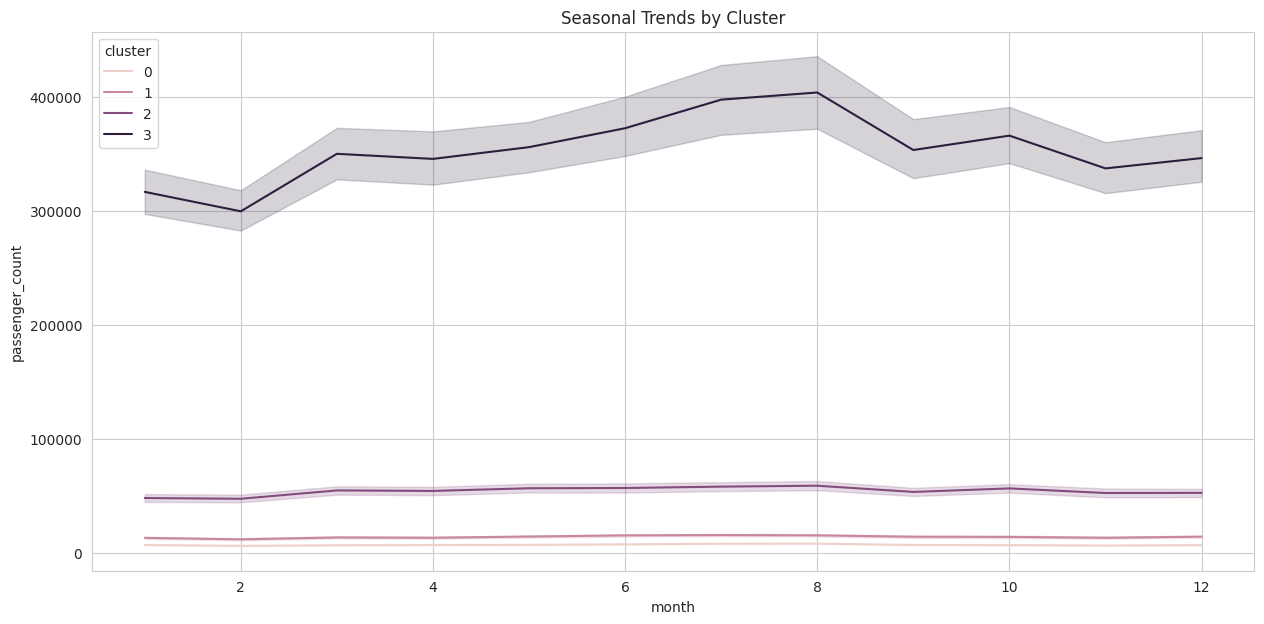

In [ ]:
sns.lineplot(x='month', y='passenger_count', hue='cluster', data=df)
plt.title("Seasonal Trends by Cluster")
plt.show()

Cluster-wise regression error summary:


,cluster,mean_actual,mean_predicted,mean_abs_error,mean_pct_error,sample_size
0,0,7357.578563,16968.361166,16522.448569,-6363.247707,17680
1,1,14390.273507,18456.872873,21172.007865,2297.978268,11305
2,2,54537.995675,53951.337057,36757.558733,-1033.425933,8323
3,3,355520.766892,119576.917707,235943.849185,65.1771,888


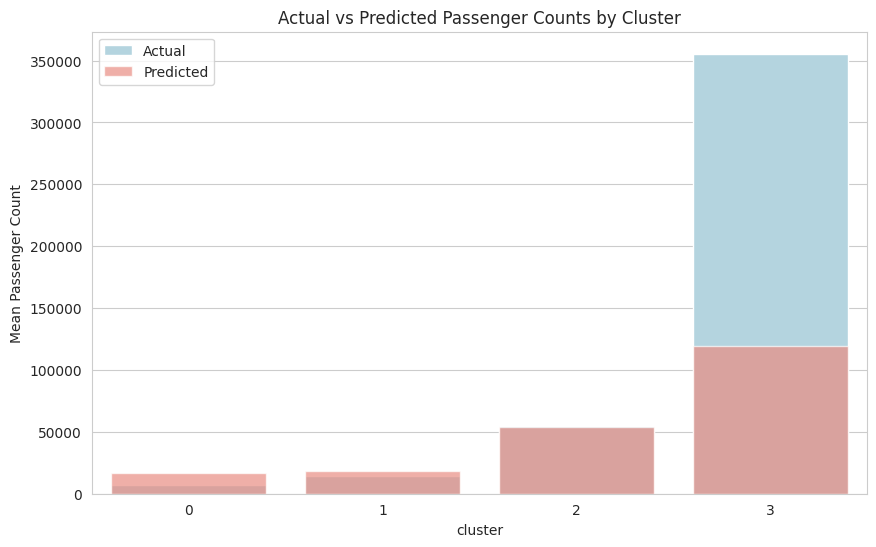

/tmp/ipython-input-2693205698.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='mean_pct_error', data=error_summary, palette='viridis')


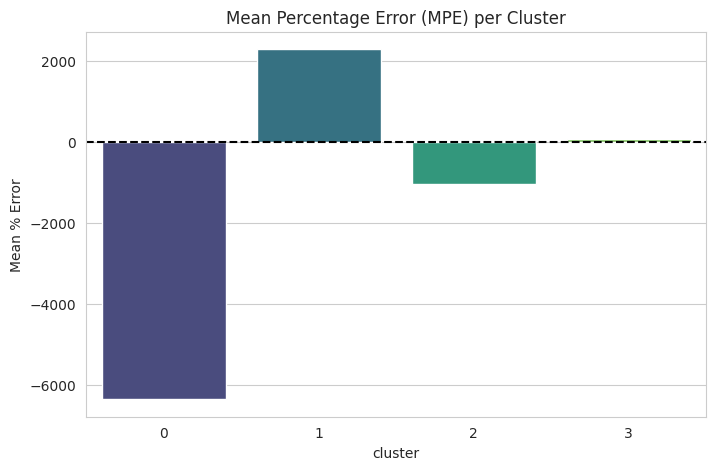

/tmp/ipython-input-2693205698.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='pct_error', data=df, palette='coolwarm')


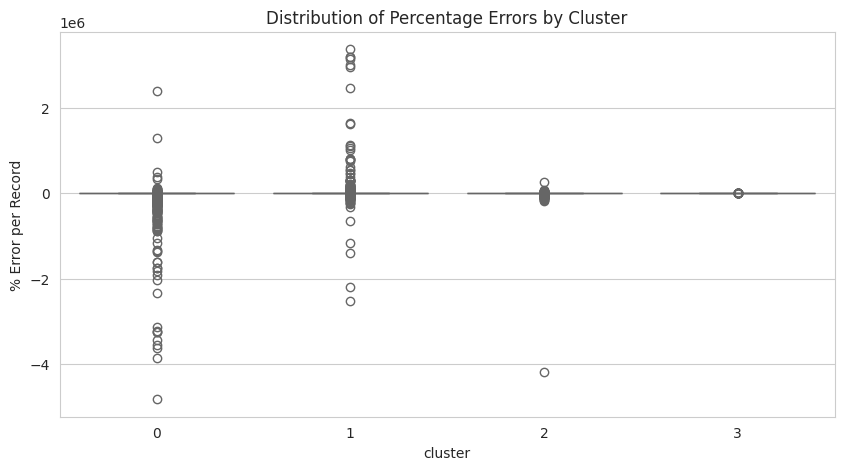

In [ ]:
# 📈 Regression vs Cluster Validation & Error Analysis (zero-safe version)

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Identify categorical columns used originally in regression ---
categorical_cols = ['activity_type_code', 'geo_summary', 'terminal', 'boarding_area']

# --- 2. One-hot encode them (drop_first=True for consistency) ---
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --- 3. Align encoded dataframe with the columns used in final backward elimination model ---
X_all = df_encoded.reindex(columns=X_be.columns, fill_value=0)
X_all_sm = sm.add_constant(X_all)

# --- 4. Generate predictions using the final model ---
df['predicted_passengers'] = final_model.predict(X_all_sm)

# --- 5. Compute absolute and relative errors safely (avoid divide by zero) ---
df['error'] = df['passenger_count'] - df['predicted_passengers']

# Replace 0 or NaN passenger counts with NaN to avoid division errors
df['safe_passenger_count'] = df['passenger_count'].replace(0, np.nan)
df['pct_error'] = (df['error'] / df['safe_passenger_count']) * 100

# --- 6. Summarize error by cluster ---
error_summary = df.groupby('cluster').agg(
    mean_actual=('passenger_count', 'mean'),
    mean_predicted=('predicted_passengers', 'mean'),
    mean_abs_error=('error', lambda x: np.mean(np.abs(x))),
    mean_pct_error=('pct_error', 'mean'),
    sample_size=('passenger_count', 'count')
).reset_index()

print("Cluster-wise regression error summary:")
display(error_summary)

# --- 7. Visualization: Actual vs Predicted by Cluster ---
plt.figure(figsize=(10,6))
sns.barplot(x='cluster', y='mean_actual', data=error_summary, color='lightblue', label='Actual')
sns.barplot(x='cluster', y='mean_predicted', data=error_summary, color='salmon', alpha=0.7, label='Predicted')
plt.title("Actual vs Predicted Passenger Counts by Cluster")
plt.ylabel("Mean Passenger Count")
plt.legend()
plt.show()

# --- 8. Visualization: Mean Percentage Error by Cluster ---
plt.figure(figsize=(8,5))
sns.barplot(x='cluster', y='mean_pct_error', data=error_summary, palette='viridis')
plt.axhline(0, color='black', linestyle='--')
plt.title("Mean Percentage Error (MPE) per Cluster")
plt.ylabel("Mean % Error")
plt.show()

# --- 9. Optional: Detailed per-cluster error distribution ---
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster', y='pct_error', data=df, palette='coolwarm')
plt.title("Distribution of Percentage Errors by Cluster")
plt.ylabel("% Error per Record")
plt.show()


In [ ]:
# PROPHET FORECASTING

# Convert to datetime
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# Aggregate passenger counts by month
monthly_passengers = (
    df.groupby('date')['passenger_count']
      .sum()
      .reset_index()
      .rename(columns={'date': 'ds', 'passenger_count': 'y'})
      .sort_values('ds')
)

display(monthly_passengers.head())


,ds,y
0,1999-07-01,3976746
1,1999-08-01,3972694
2,1999-09-01,3341964
3,1999-10-01,3468846
4,1999-11-01,3145240


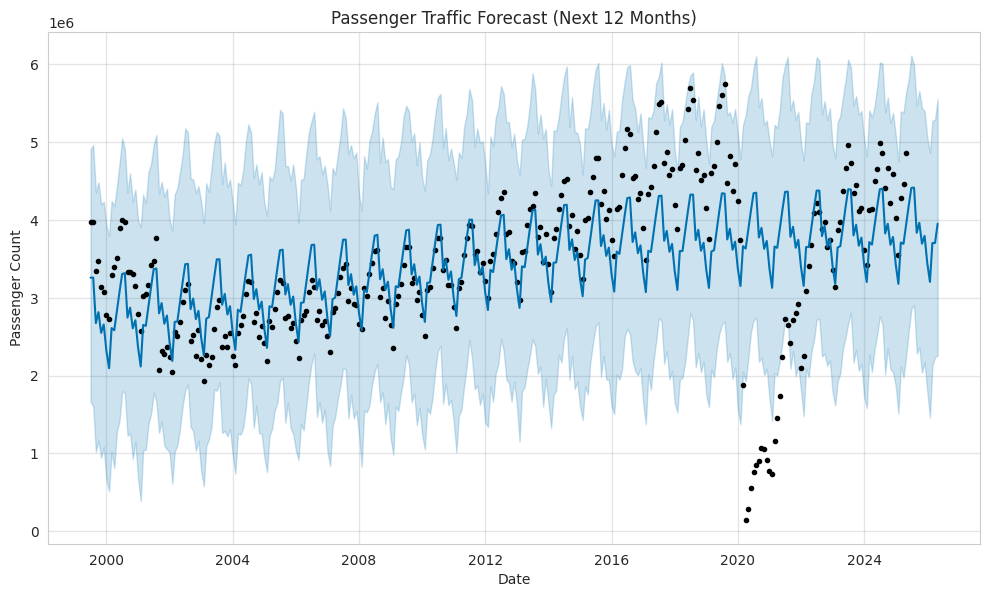

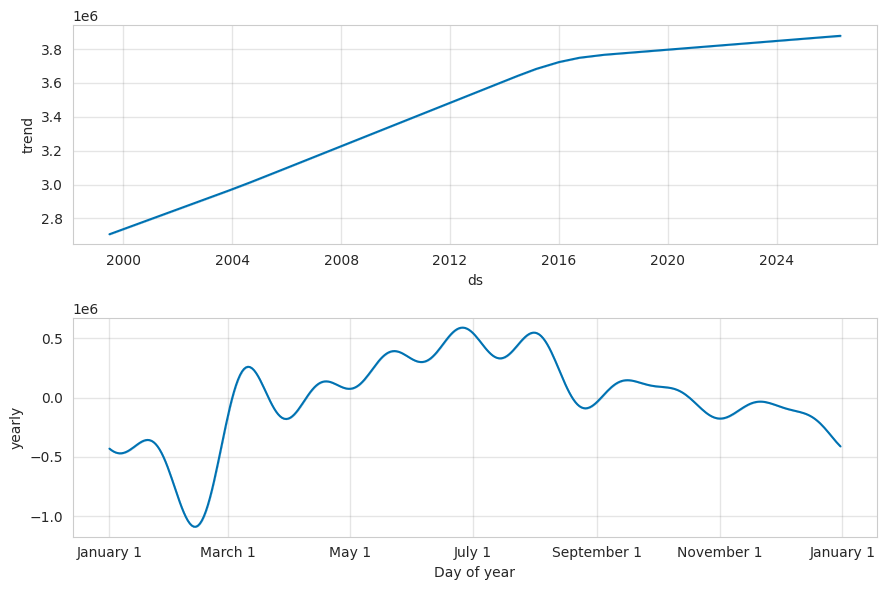

In [ ]:
# Forecasting with Prophet

from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize Prophet model with seasonality components
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    interval_width=0.95
)

# Fit the model
model.fit(monthly_passengers)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='MS')  # 'MS' = month start
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Passenger Traffic Forecast (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.show()

# Plot components (trend, yearly seasonality)
model.plot_components(forecast)
plt.show()


In [ ]:
# Compare actual vs predicted for last 6 months
actual = monthly_passengers.set_index('ds')
pred = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]

merged = actual.join(pred, how='inner').dropna()
merged['error'] = merged['y'] - merged['yhat']
merged['pct_error'] = (merged['error'] / merged['y']) * 100

print("Mean Absolute Percentage Error (MAPE):", abs(merged['pct_error']).mean())
display(merged.tail(12))


Mean Absolute Percentage Error (MAPE): 36.6343541808969


,y,yhat,yhat_lower,yhat_upper,error,pct_error
ds,,,,,,
2024-06-01,4654071,4.173681e+06,2.524596e+06,5.714029e+06,480389.867397,10.321928
2024-07-01,4989844,4.395359e+06,2.764128e+06,6.024516e+06,594485.231559,11.913904
2024-08-01,4860068,4.402822e+06,2.658706e+06,6.012287e+06,457246.373721,9.408230
2024-09-01,4409452,3.827749e+06,2.012890e+06,5.383202e+06,581703.382877,13.192192
2024-10-01,4671217,3.951147e+06,2.357877e+06,5.576843e+06,720069.962034,15.415040
2024-11-01,4224750,3.682253e+06,2.085465e+06,5.242439e+06,542496.896188,12.840923
2024-12-01,4592649,3.782419e+06,2.042263e+06,5.379338e+06,810229.696981,17.641882
2025-01-01,4025815,3.430758e+06,1.866606e+06,5.091537e+06,595057.084260,14.781034
2025-02-01,3544840,3.179983e+06,1.511435e+06,4.750695e+06,364856.876238,10.292619


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


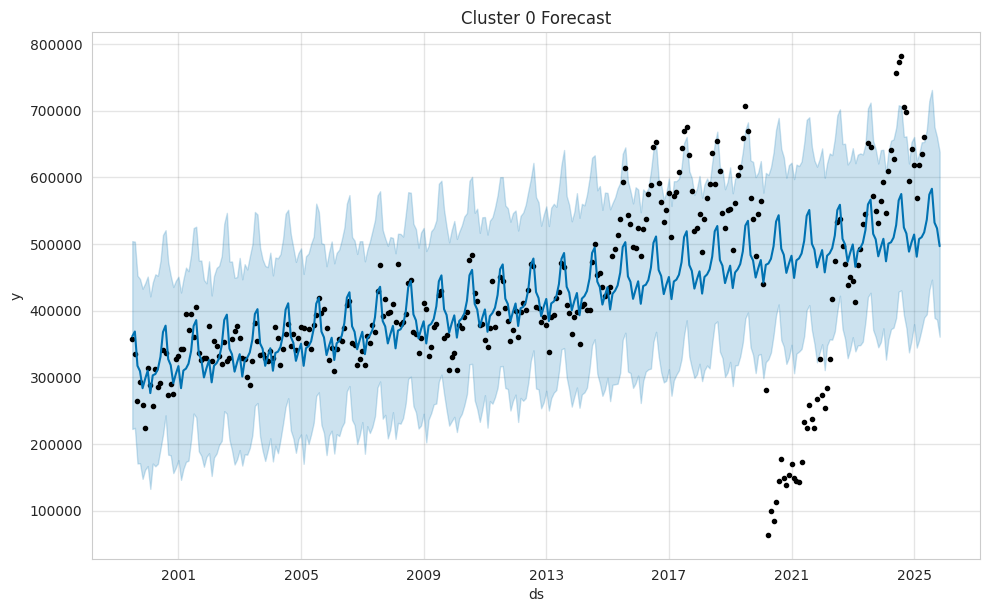

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


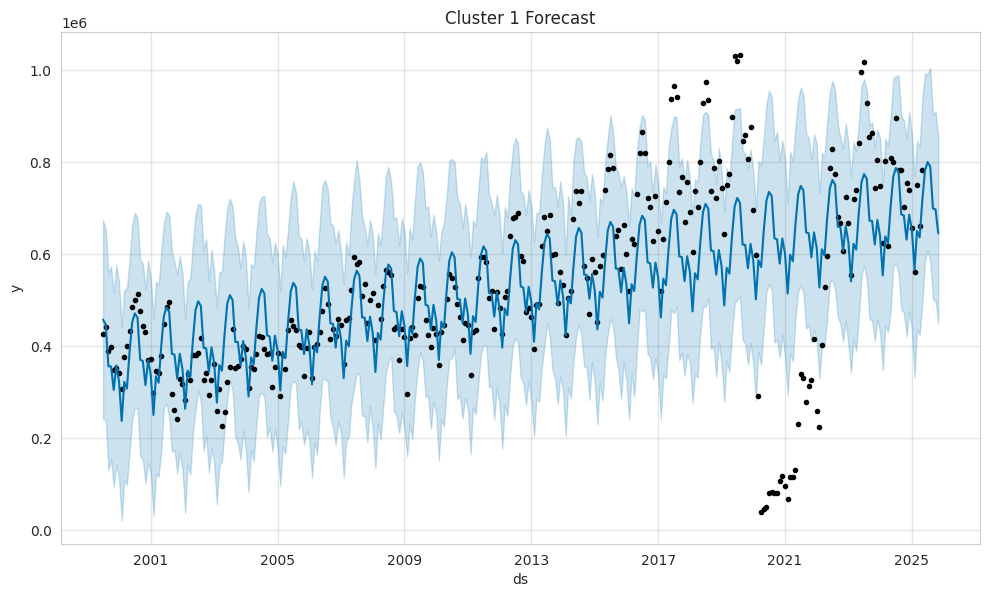

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


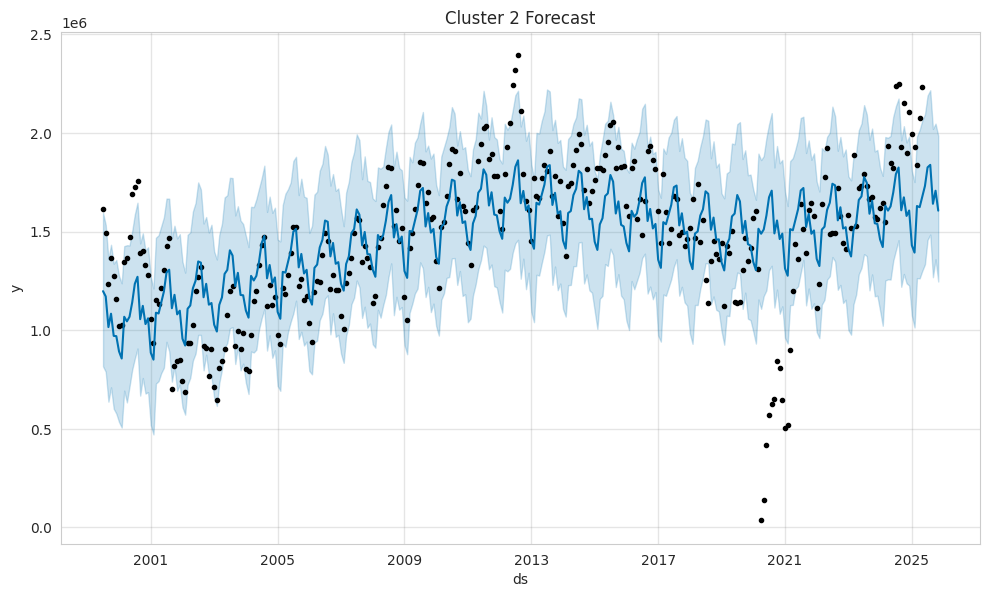

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


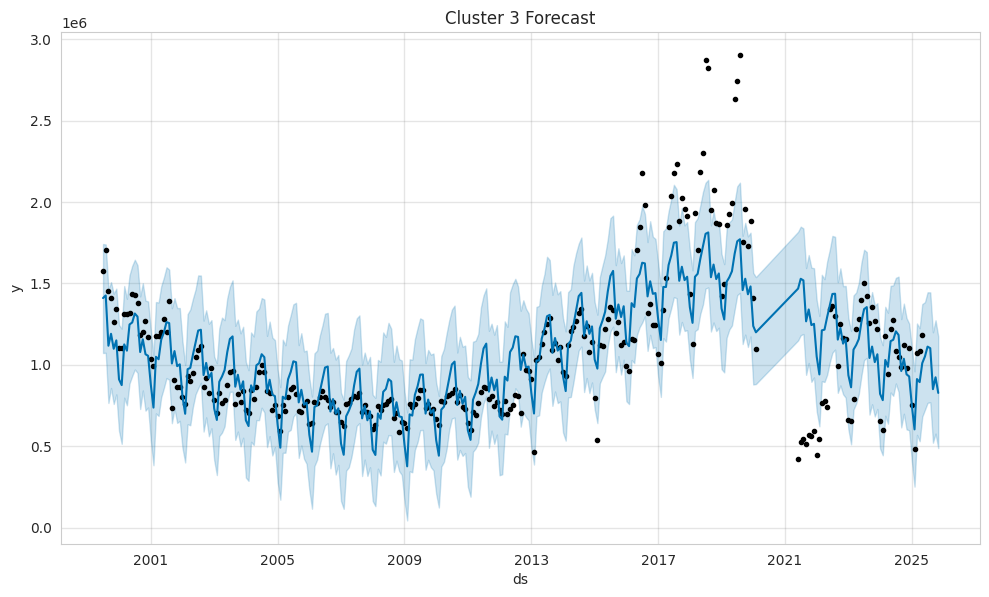

In [ ]:
for c in sorted(df['cluster'].unique()):
    temp = (df[df['cluster'] == c]
            .groupby('date')['passenger_count']
            .sum()
            .reset_index()
            .rename(columns={'date': 'ds', 'passenger_count': 'y'}))

    model = Prophet(yearly_seasonality=True)
    model.fit(temp)
    future = model.make_future_dataframe(periods=6, freq='MS')
    forecast = model.predict(future)

    model.plot(forecast)
    plt.title(f"Cluster {c} Forecast")
    plt.show()


In [ ]:
# FEATURE ENGINEERING

# Assuming your dataframe is called df and has 'month', 'year', and 'passenger_count'

# Load cleaned data
import pandas as pd
import numpy as np

df = pd.read_csv("/content/fully_cleaned_sfo_passenger_data.csv")

df = df.sort_values(by=['year', 'month']).reset_index(drop=True)

# --- 1. Create lag features ---
df['passengers_lag1'] = df['passenger_count'].shift(1)
df['passengers_lag2'] = df['passenger_count'].shift(2)
df['passengers_lag3'] = df['passenger_count'].shift(3)

# --- 2. Rolling window averages ---
df['rolling_mean_3'] = df['passenger_count'].rolling(window=3).mean()
df['rolling_std_3'] = df['passenger_count'].rolling(window=3).std()

# --- 3. Growth rates ---
# Handle division by zero by replacing resulting infinities with NaN
df['monthly_growth'] = df['passenger_count'].pct_change() * 100
df['monthly_growth'] = df['monthly_growth'].replace([np.inf, -np.inf], np.nan)


# --- 4. Temporal (cyclic) features ---
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# --- 5. Handle missing values from shifting and now growth rate ---
df = df.dropna().reset_index(drop=True)

print(" Feature engineering complete. Shape:", df.shape)
df.head()

 Feature engineering complete. Shape: (38191, 26)


,activity_period,activity_period_start_date,operating_airline,operating_airline_iata_code,published_airline,published_airline_iata_code,geo_summary,geo_region,activity_type_code,price_category_code,...,month,month_name,passengers_lag1,passengers_lag2,passengers_lag3,rolling_mean_3,rolling_std_3,monthly_growth,month_sin,month_cos
0,1999-07-01,1999-07-01,Aeroflot Russian International Airlines,Unknown,Aeroflot Russian International Airlines,Unknown,International,Europe,Deplaned,Other,...,7,July,2518.0,31353.0,31432.0,11731.666667,17003.057088,-47.418586,-0.5,-0.866025
1,1999-07-01,1999-07-01,Aeroflot Russian International Airlines,Unknown,Aeroflot Russian International Airlines,Unknown,International,Europe,Enplaned,Other,...,7,July,1324.0,2518.0,31353.0,1680.000000,728.458647,-9.516616,-0.5,-0.866025
2,1999-07-01,1999-07-01,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,...,7,July,1198.0,1324.0,2518.0,8882.000000,13200.109545,1913.689482,-0.5,-0.866025
3,1999-07-01,1999-07-01,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,...,7,July,24124.0,1198.0,1324.0,16311.666667,13091.312781,-2.118223,-0.5,-0.866025
4,1999-07-01,1999-07-01,Air China,CA,Air China,CA,International,Asia,Deplaned,Other,...,7,July,23613.0,24124.0,1198.0,17573.333333,10906.541630,-78.897218,-0.5,-0.866025


In [ ]:
# 🧠 STEP 3 — CLASSIFICATION (Traffic Level Prediction)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Create categorical labels based on quantiles ---
df['traffic_level'] = pd.qcut(df['passenger_count'], q=3, labels=['Low', 'Medium', 'High'])

# --- 2. Feature selection ---
X_cls = df[features]
y_cls = df['traffic_level']

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, shuffle=False)

# --- 3. Train a Random Forest Classifier ---
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)

y_pred_cls = rf.predict(X_test)

# --- 4. Evaluation ---
print(" Classification Report:")
print(classification_report(y_test, y_pred_cls))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cls))


📈 Classification Report:
              precision    recall  f1-score   support

        High       0.98      0.98      0.98      2209
         Low       0.98      0.98      0.98      3140
      Medium       0.97      0.96      0.96      2290

    accuracy                           0.98      7639
   macro avg       0.98      0.98      0.98      7639
weighted avg       0.98      0.98      0.98      7639

Confusion Matrix:
 [[2173    0   36]
 [  13 3089   38]
 [  29   59 2202]]


In [ ]:

# --- 1. Normalize data ---
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# --- 2. Build Autoencoder ---
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mae')

# --- 3. Train ---
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

# --- 4. Reconstruction error ---
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.abs(reconstructions - X_scaled), axis=1)
threshold = np.percentile(mse, 95)

# --- 5. Flag anomalies ---
df['anomaly_score'] = mse
df['is_anomaly'] = df['anomaly_score'] > threshold

print(f"Anomaly detection complete. {df['is_anomaly'].sum()} anomalies found.")
df[df['is_anomaly'] == True][['year', 'month', 'passenger_count', 'anomaly_score']].head()


1194/1194 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Anomaly detection complete. 1910 anomalies found.


,year,month,passenger_count,anomaly_score
113,1999,7,784782,0.001676
114,1999,7,792965,0.001155
115,1999,7,16837,0.001762
116,1999,7,51309,0.001321
240,1999,8,856501,0.000740


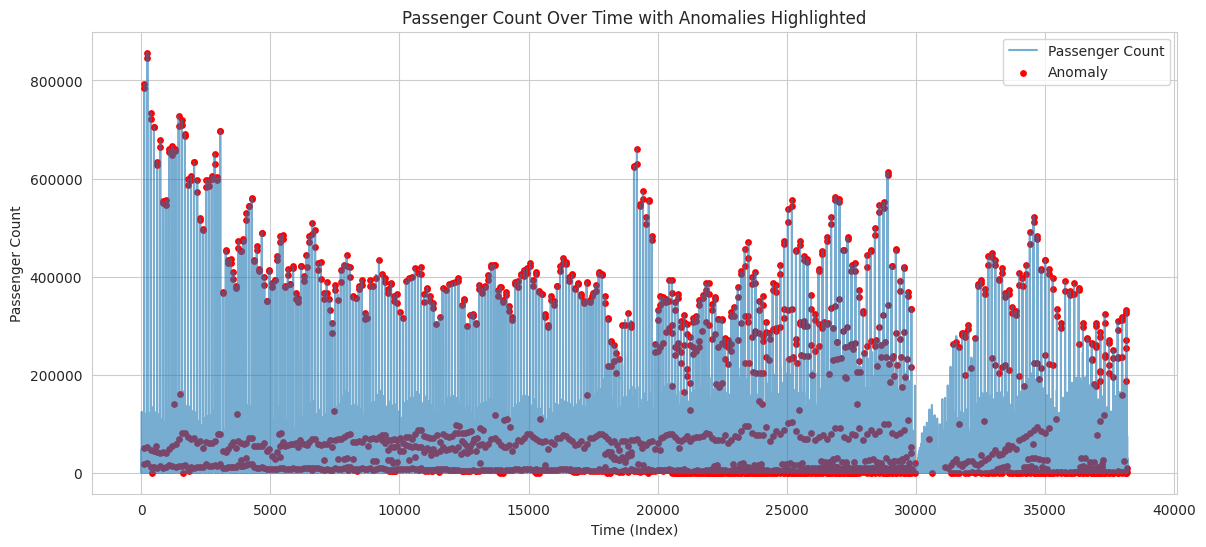

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['passenger_count'], label='Passenger Count', alpha=0.6)
plt.scatter(df.index[df['is_anomaly']], df.loc[df['is_anomaly'], 'passenger_count'],
            color='red', label='Anomaly', s=15)
plt.title("Passenger Count Over Time with Anomalies Highlighted")
plt.xlabel("Time (Index)")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()
